## Setup

In [1]:
import sys
sys.path.append('../')
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm

from src.generateIP import generate_knapsack_ip
from src.IP import *
from src.LTNN import *
from src.data_loader import *
from src.DDPG import *
from src.env import *
from src.train import *

import time
import torch
import torch.nn as nn
import torch.optim as optim


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

N, K = 16, 2
num_samples = 5000
buffer_size = 6000
random_seed = 0
minimal_size = 1024
num_cuts = 1
batch_size = 128
epochs = 5

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)



file_paths = [f"../data/knapsack_train/knapsack_ip_train_{i}.pt" for i in range(num_samples)]
dataset = KnapsackDataset(file_paths)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

env = IPenv(file_paths, N+K+2*N*K, N*K, num_cuts, device, "knapsack")


In [3]:
agent = DDPG(N=N, 
             K=K, 
             num_cuts=num_cuts, 
             hidden_channels_actor=[256,256], 
             hidden_channels_critic=[64,32], 
             activation="StepSigmoid", 
             squeeze="Sigmoid", 
             use_bn=False, 
             sigma=0.01, 
             actor_lr=3e-4, 
             critic_lr=3e-3, 
             tau=0.01, 
             gamma=0.9, 
             device=device, 
             problem_type="knapsack")

replay_buffer = ReplayBuffer(buffer_size)

## Training

In [4]:
return_list = train(env, agent, num_samples, replay_buffer, minimal_size, batch_size, epochs)

Epoch 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-25


Epoch 5: 100%|██████████| 5000/5000 [05:22<00:00, 15.48it/s, Return=-4.12, Moving Avg Return=5.11]   


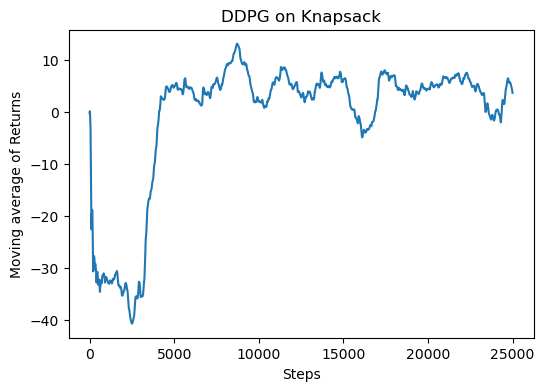

In [5]:
plt.figure(figsize=(6,4))
plt.subplot(1,1,1)
episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, min(1000, len(return_list)))
episodes_list = list(range(len(mv_return)))
plt.plot(episodes_list, mv_return)
plt.xlabel('Steps')
plt.ylabel('Moving average of Returns')
plt.title('DDPG on Knapsack')
plt.show()
np.save("../data/moving_returns_LTNN.npy", mv_return) 

In [6]:
test_size = 1000  
test_file_paths = [f"../data/knapsack_test/knapsack_ip_test_{i}.pt" for i in range(test_size)]
after_treesize = []
agent.actor.eval()

for i in tqdm(range(test_size)):
    loaded_dict = torch.load(test_file_paths[i])
    ip_tensor_i = loaded_dict['ip_tensor']
    treesize_i = loaded_dict['treesize']
    ip_object_i = vector_to_ip(ip_tensor_i, N+K+2*N*K, N*K, problem_type="knapsack")
    u = agent.actor(torch.cat((ip_tensor_i[0:16], ip_tensor_i[-82:-80]), dim=0).cuda()).cpu().detach().numpy()
    ip_object_i.add_sequence_chvatal_cut(u, 1)
    ip_object_i.optimize()
    after_treesize.append(ip_object_i.treesize)

print(f"Average Tree Size after 1 LT agent generated Chvatal Cut (on unseen test set of size 1000): {np.mean(after_treesize)}")

100%|██████████| 1000/1000 [00:53<00:00, 18.79it/s]

Average Tree Size after 1 LT agent generated Chvatal Cut (on unseen test set of size 1000): 191.871
